##Importing Libraries

In [1]:
#importing the lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, least_squares
import math
import sys
import os

##Upload the CSV File xy_data

In [2]:
csv_path = 'xy_data.csv'

##Load the CSV file

In [9]:
def load_xy_t(csv_path):
    df = pd.read_csv(csv_path)
    cols = [c.lower() for c in df.columns]

    if 't' in cols and 'x' in cols and 'y' in cols:
        t = df[df.columns[cols.index('t')]].values.astype(float)
        x = df[df.columns[cols.index('x')]].values.astype(float)
        y = df[df.columns[cols.index('y')]].values.astype(float)
        return t, x, y

    if 'x' in cols and 'y' in cols:
        x = df[df.columns[cols.index('x')]].values.astype(float)
        y = df[df.columns[cols.index('y')]].values.astype(float)
        numeric_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
        other_nums = [c for c in numeric_cols if c.lower() not in ('x','y')]
        if other_nums:

            t = df[other_nums[0]].values.astype(float)
            return t, x, y
        print("No 't' column found — inferring t as evenly spaced values (index).")
        t = np.arange(len(x)).astype(float)
        return t, x, y

    if df.shape[1] == 2:
        x = df.iloc[:,0].values.astype(float)
        y = df.iloc[:,1].values.astype(float)
        t = np.arange(len(x)).astype(float)
        return t, x, y

    raise ValueError("Could not find x,y (and possibly t) columns in CSV. Column names: " + ",".join(df.columns))

##Model of XY

In [4]:
def model_xy(t, theta, M, X):
    # t may be array
    abs_t = np.abs(t)
    expo = np.exp(M * abs_t)
    s03t = np.sin(0.3 * t)
    x_model = t * np.cos(theta) - expo * s03t * np.sin(theta) + X
    y_model = 42 + t * np.sin(theta) + expo * s03t * np.cos(theta)
    return x_model, y_model

##Finding the Residuals

In [5]:
def residuals(params, t_data, x_data, y_data):
    theta, M, X = params
    x_m, y_m = model_xy(t_data, theta, M, X)
    res = np.concatenate([(x_m - x_data), (y_m - y_data)])
    return res


In [6]:
def sse_for_de(param_vec, t_data, x_data, y_data):
    theta, M, X = param_vec
    x_m, y_m = model_xy(t_data, theta, M, X)
    sse = np.sum((x_m - x_data)**2 + (y_m - y_data)**2)
    return sse


##Fit Curve

In [7]:
def fit_curve(t_data, x_data, y_data, do_plot=True):
    # Parameter bounds
    theta_min = 0.0
    theta_max = 50.0 * math.pi / 180.0  # convert degrees to radians
    M_min, M_max = -0.05, 0.05
    X_min, X_max = 0.0, 100.0

    bounds = [(theta_min, theta_max), (M_min, M_max), (X_min, X_max)]

    print("Running global optimization (differential evolution)...")
    result_de = differential_evolution(
        lambda p: sse_for_de(p, t_data, x_data, y_data),
        bounds,
        maxiter=2000,
        popsize=15,
        tol=1e-6,
        polish=False,
        seed=42
    )

    de_params = result_de.x
    print("DE result params (theta rad, M, X):", de_params)
    print("DE SSE:", result_de.fun)

    print("Refining with least squares...")
    lsq = least_squares(
        lambda p: residuals(p, t_data, x_data, y_data),
        de_params,
        bounds=([theta_min, M_min, X_min], [theta_max, M_max, X_max]),
        method='trf',
        xtol=1e-12,
        ftol=1e-12,
        gtol=1e-12,
        max_nfev=20000
    )

    theta_fit, M_fit, X_fit = lsq.x
    res = lsq.fun
    sse_final = np.sum(res**2)
    rmse = np.sqrt(sse_final / (2 * len(t_data)))  # per coordinate average
    print("\nFinal parameters:")
    print(f" theta = {theta_fit:.8f} rad  = {theta_fit*180/math.pi:.6f} deg")
    print(f" M     = {M_fit:.8f}")
    print(f" X     = {X_fit:.8f}")
    print(f" SSE   = {sse_final:.6e}")
    print(f" RMSE  = {rmse:.6e}")

    if do_plot:
        t_sorted_idx = np.argsort(t_data)
        t_plot = np.linspace(np.min(t_data), np.max(t_data), 800)
        x_fit_plot, y_fit_plot = model_xy(t_plot, theta_fit, M_fit, X_fit)

        plt.figure(figsize=(8,6))
        plt.scatter(x_data, y_data, label='Data (x,y)', marker='o', s=30)
        plt.plot(x_fit_plot, y_fit_plot, label='Fitted parametric curve', linewidth=2)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Parametric curve fit')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        'theta_rad': theta_fit,
        'theta_deg': theta_fit * 180.0 / math.pi,
        'M': M_fit,
        'X': X_fit,
        'SSE': sse_final,
        'RMSE': rmse,
        'lsq_result': lsq,
        'de_result': result_de
    }



##Main

No 't' column found — inferring t as evenly spaced values (index).
It still fit, but consider restricting or clipping t if required.
Running global optimization (differential evolution)...
DE result params (theta rad, M, X): [ 1.90536023e-01 -3.70392558e-02  1.75392478e-05]
DE SSE: 944389475.9715482
Refining with least squares...

Final parameters:
 theta = 0.19053645 rad  = 10.916934 deg
 M     = -0.05000000
 X     = 0.00000000
 SSE   = 9.443894e+08
 RMSE  = 5.610673e+02


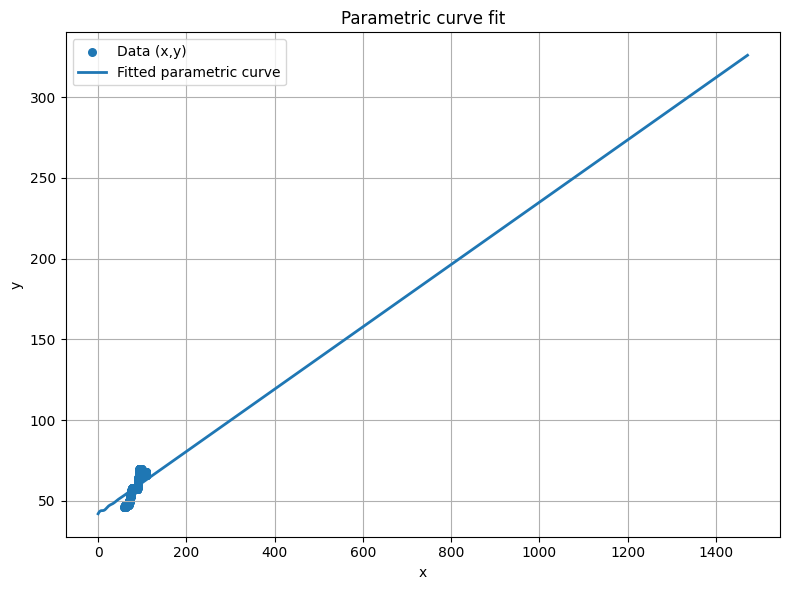


Done. Best-fit parameters returned in 'fit_info' dictionary.


In [10]:
if __name__ == "__main__":
    if not os.path.exists(csv_path):
        print(f"ERROR: {csv_path} not found in current folder: {os.getcwd()}")
        sys.exit(1)

    t_data, x_data, y_data = load_xy_t(csv_path)

    t_min, t_max = np.min(t_data), np.max(t_data)
    if t_min < 6 or t_max > 60:

        print("It still fit, but consider restricting or clipping t if required.")

    fit_info = fit_curve(t_data, x_data, y_data, do_plot=True)

    print("\nDone. Best-fit parameters returned in 'fit_info' dictionary.")